# Reconstruction of Bragg peak $\langle111\rangle$-A of a single grain from Andrew's gold thin film

The success with the gold 'standard sample' from Ross's dewetted film is encouraging. That reconstruction also gave us a good idea of what the partial coherence parameters are. Here we use them as an initial guess dur PCC during phasing.

In [8]:
# basic imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
import time

# Scipy modules
import scipy.optimize as spopt
import scipy.fftpack as spfft
import scipy.io as sio

# Sepcialty modules: FFTs, LASSO regressions
# from pyfftw.interfaces.numpy_fft import fftshift, fftn, ifftn
from numpy.fft import fftshift, fftn, ifftn
from sklearn.linear_model import Lasso

# Custom modules
import TilePlot as tp
import SuperSampling as ss
from customTransform import *
import FastPhaseRetriever as fpr
import Binning as bng

# GPU computations module
import tensorflow as tf

# Miscellaneous
from tqdm import tqdm, tnrange, tqdm_notebook
import gc
import tifffile as tfile

In [9]:
%matplotlib notebook

In [12]:
dataNoisy = sio.loadmat( '/home/smaddali/Sector1/111-A.mat' )[ 'data' ]
shp = dataNoisy.shape
datNoisy = dataNoisy[ 
    ( shp[0]//2 - 64 ):    ( shp[0]//2 + 64 ), 
    ( shp[1]//2 - 64 ):    ( shp[1]//2 + 64 ), 
    ( shp[2]//2 - 30 ):    ( shp[2]//2 + 30 )
]

In [14]:
shp

(238, 238, 60)

In [13]:
dataNoisy.shape

(238, 238, 60)

In [4]:
mySup = np.zeros( dataNoisy.shape )

N = [ n // 3 for n in mySup.shape ] # size of support

mySup[ 
    ( ( mySup.shape[0]-N[0] )//2 ):( ( mySup.shape[0]+N[0] )//2+2 ), 
    ( ( mySup.shape[1]-N[1] )//2 ):( ( mySup.shape[1]+N[1] )//2-2 ), 
    ( ( mySup.shape[2]-N[2] )//2 ):( ( mySup.shape[2]+N[2] )//2+2 )
     ] = 1.

In [5]:
temp = dataNoisy.copy()
temp[ np.where( temp==0. ) ] = np.unique( np.sort( temp.ravel() ) )[1]

<IPython.core.display.Javascript object>


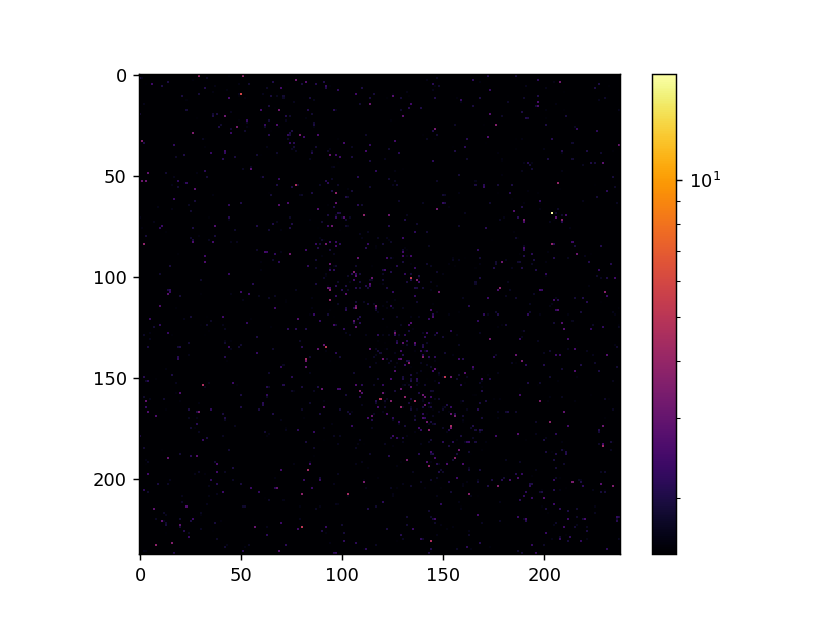

In [6]:
fig = plt.figure()
plt.set_cmap( 'inferno' )
for n in list( range( temp.shape[-1] ) ):
    plt.clf()
    plt.imshow( temp[:,:,n], norm=LogNorm() )
    plt.colorbar()
    fig.canvas.draw()
    plt.pause( 0.03125 )
# plt.imshow( dataNoisy[:,:,n], norm=LogNorm() )
# plt.colorbar()
# plt.title( 'Standard sample central slice' )

In [7]:
dataNoisy.shape

(238, 238, 60)

In [ ]:
guess_params = sio.loadmat( '../stdSample_solution.mat' )[ 'pcc_params' ][0]
print( guess_params )

In [ ]:
PRG = fpr.PhaseRetriever( 
    modulus=np.sqrt( dataNoisy ), 
    support=mySup.copy(), 
    beta=0.9, 
    binning=1, 
    initial_pcc_guess=guess_params,
    gpu=True, 
    num_gpus=2
).gpusolver

In [ ]:
N = 75
sig = np.linspace( 3., 1., N )
thresh = np.linspace( 0.2, 0.1, N )

# thresh2 = np.linspace( 0.15, 0.1, N )
# frac = np.linspace( 0.3, 1., N )

frac = np.ones( N )
# frac[:75] = 0.8
# frac[75:] = np.linspace( 0.8, 1., 25 )

In [ ]:
for n in tqdm( list( range( N ) ), desc=' ER' ):
    PRG.PCER( 50 )
    PRG.Shrinkwrap( sig[n], thresh[n] )
    if n >= N//3:
        PRG.GaussPCC( 
            min_iterations=10, 
            max_iterations=30, 
            iterations_per_checkpoint=100, 
            mask_fraction=frac[n] 
        )
        
PRG.HIO( 150 )

for n in tqdm( list( range( N ) ), desc=' ER' ):
    PRG.PCER( 50 )
    PRG.Shrinkwrap( sig[-1], thresh[-1] )
    if n <= 2*N//3:
        PRG.GaussPCC( 
            min_iterations=10, 
            max_iterations=30, 
            iterations_per_checkpoint=100, 
            mask_fraction=frac[n] 
        )

In [ ]:
PRG.Retrieve()

In [ ]:
imgOut = PRG.finalImage
supOut = PRG.finalSupport
blurFinal = PRG.finalPCC
varList = PRG.finalGaussPCCParams

In [ ]:
imgOut.shape

In [ ]:
plt.figure()
# plt.imshow( supOut[:,:,33] * np.angle( imgOut[:,:,33] )  )
plt.imshow( np.angle( imgOut[:,:,30] ) )
# plt.imshow( blurFinal[64,:,:], norm=LogNorm() )
plt.colorbar()

In [ ]:
ftmod = np.absolute( fftshift( fftn( fftshift( imgOut ) ) ) )**2
fig, im, ax = tp.TilePlot( 
    ( dataNoisy[:,:,33], ftmod[:,:,33] ), 
    ( 1, 2 ), ( 10, 5 ), 
    log_norm=True
)
ax[0].set_title( 'Observed signal' )
ax[1].set_title( 'Inferred far-field propagation' )

In [ ]:
# mydict = { 
#     'data':dataNoisy, 
#     'intensity':ftmod, 
#     'rho':imgOut,
#     'support':supOut,
#     'coh_func':blurFinal, 
#     'pcc_params':varList
# }
# sio.savemat( '/home/smaddali/Sector1/111-A_solution.mat', mydict )